## Import Module
Disini pembuatan modelnya menggunakan Keras

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

## Mount Google Drive
Pastikan Link: https://drive.google.com/drive/folders/1cD5paKyz6F3C0W8JPUeH-NTPCaKm1PZm

dibuat shortcutnya ke folder KSC di drive masing-masing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Tutorial/Tubes/Dataset/Tomat"

/content/drive/.shortcut-targets-by-id/1cD5paKyz6F3C0W8JPUeH-NTPCaKm1PZm/Tubes/Dataset/Tomat


## Reading Dataset as ImageFolder
Membaca masing-masing dataset yang displit menjadi 80% Training, 20% Validasi

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory as imageFolder

In [5]:
path = "/content/drive/MyDrive/Tutorial/Tubes/Dataset/Tomat"
train = imageFolder(path, subset="training",validation_split=0.2, seed = 333, image_size=(256, 256))
val =imageFolder(path, subset="validation",validation_split=0.2, seed = 333, image_size=(256, 256))

Found 4500 files belonging to 3 classes.
Using 3600 files for training.
Found 4500 files belonging to 3 classes.
Using 900 files for validation.


In [6]:
import matplotlib.pyplot as plt
class_names = train.class_names
class_names

['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___healthy']

In [7]:
class_names = ["Tomato - Early Blight", "Tomato - Late Blight", "Tomato - Healthy"]
class_names

['Tomato - Early Blight', 'Tomato - Late Blight', 'Tomato - Healthy']

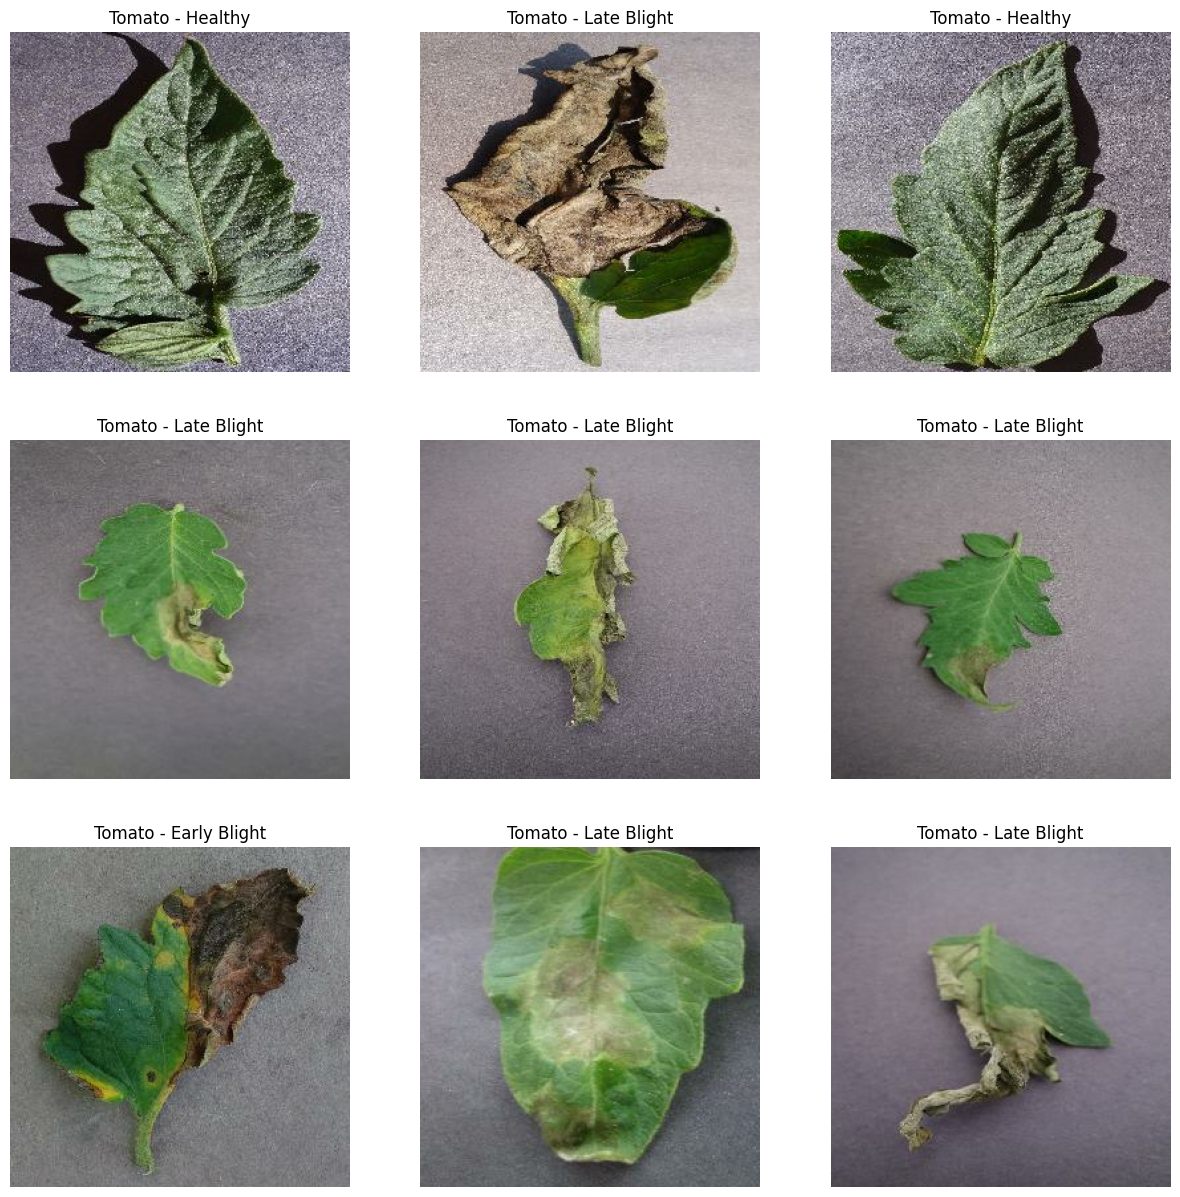

In [8]:
plt.figure(figsize=(15, 15))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Transfer Learning using ResNet50

In [9]:
input_t = K.Input(shape=(256, 256, 3))
pretrained_model = K.applications.ResNet50(include_top = False, weights = "imagenet", input_tensor = input_t)

94765736/94765736 [==============================] - 5s 0us/step


Beberapa Layer terakhir dari ResNet50 diupdate (sisanya difreeze parameternya)

Proses ini disebut juga dengan fine-tuning

In [10]:
len(pretrained_model.layers)

175

In [11]:
for layer in pretrained_model.layers[:150]:
  layer.trainable = False

Menambahkan layer fully connected sendiri untuk klasifikasi

In [15]:
model = K.models.Sequential()
#Transfer Learning
model.add(pretrained_model)
#Fully Connected Layer
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dropout(0.2))
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(3, activation='softmax'))

## Training Model
Digunakan loss function Sparse Categorical Cross Entropy dari Keras dengan Optimizer SGD (learning rate = 0.0005)

In [16]:
opt = K.optimizers.SGD(learning_rate=0.0005)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
113/113 [==============================] - 1124s 10s/step - loss: 0.4070 - accuracy: 0.8389 - val_loss: 0.2186 - val_accuracy: 0.9256
Epoch 2/20
113/113 [==============================] - 21s 178ms/step - loss: 0.1050 - accuracy: 0.9706 - val_loss: 0.1618 - val_accuracy: 0.9422
Epoch 3/20
113/113 [==============================] - 21s 184ms/step - loss: 0.0589 - accuracy: 0.9861 - val_loss: 0.1485 - val_accuracy: 0.9467
Epoch 4/20
113/113 [==============================] - 21s 185ms/step - loss: 0.0437 - accuracy: 0.9928 - val_loss: 0.1418 - val_accuracy: 0.9533
Epoch 5/20
113/113 [==============================] - 21s 181ms/step - loss: 0.0346 - accuracy: 0.9964 - val_loss: 0.1349 - val_accuracy: 0.9589
Epoch 6/20
113/113 [==============================] - 22s 195ms/step - loss: 0.0247 - accuracy: 0.9981 - val_loss: 0.1321 - val_accuracy: 0.9567
Epoch 7/20
113/113 [==============================] - 21s 183ms/step - loss: 0.0233 - accuracy: 0.9978 - val_loss: 0.1284 - val_ac

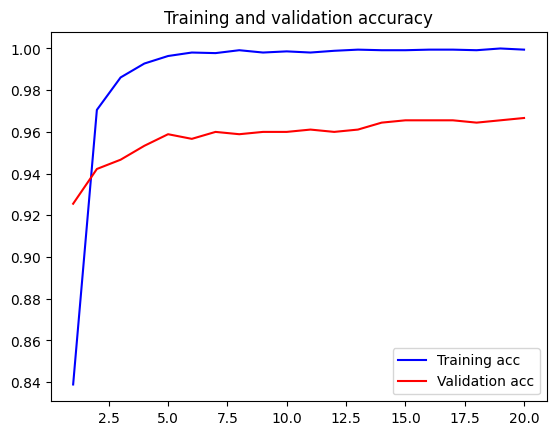

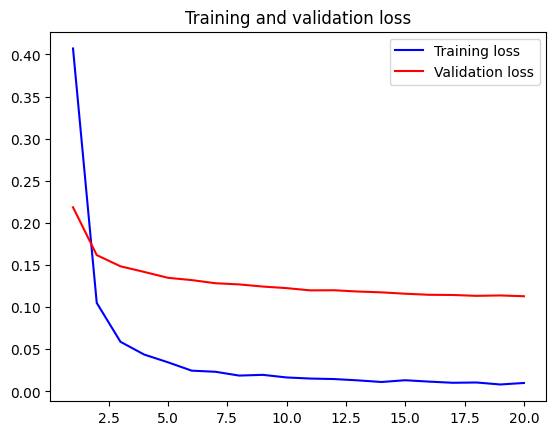

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Validasi Data

In [18]:
for image_batch, labels_batch in val:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
prediction = model.predict(image_batch)

(32, 256, 256, 3)
(32,)
1/1 [==============================] - 1s 999ms/step


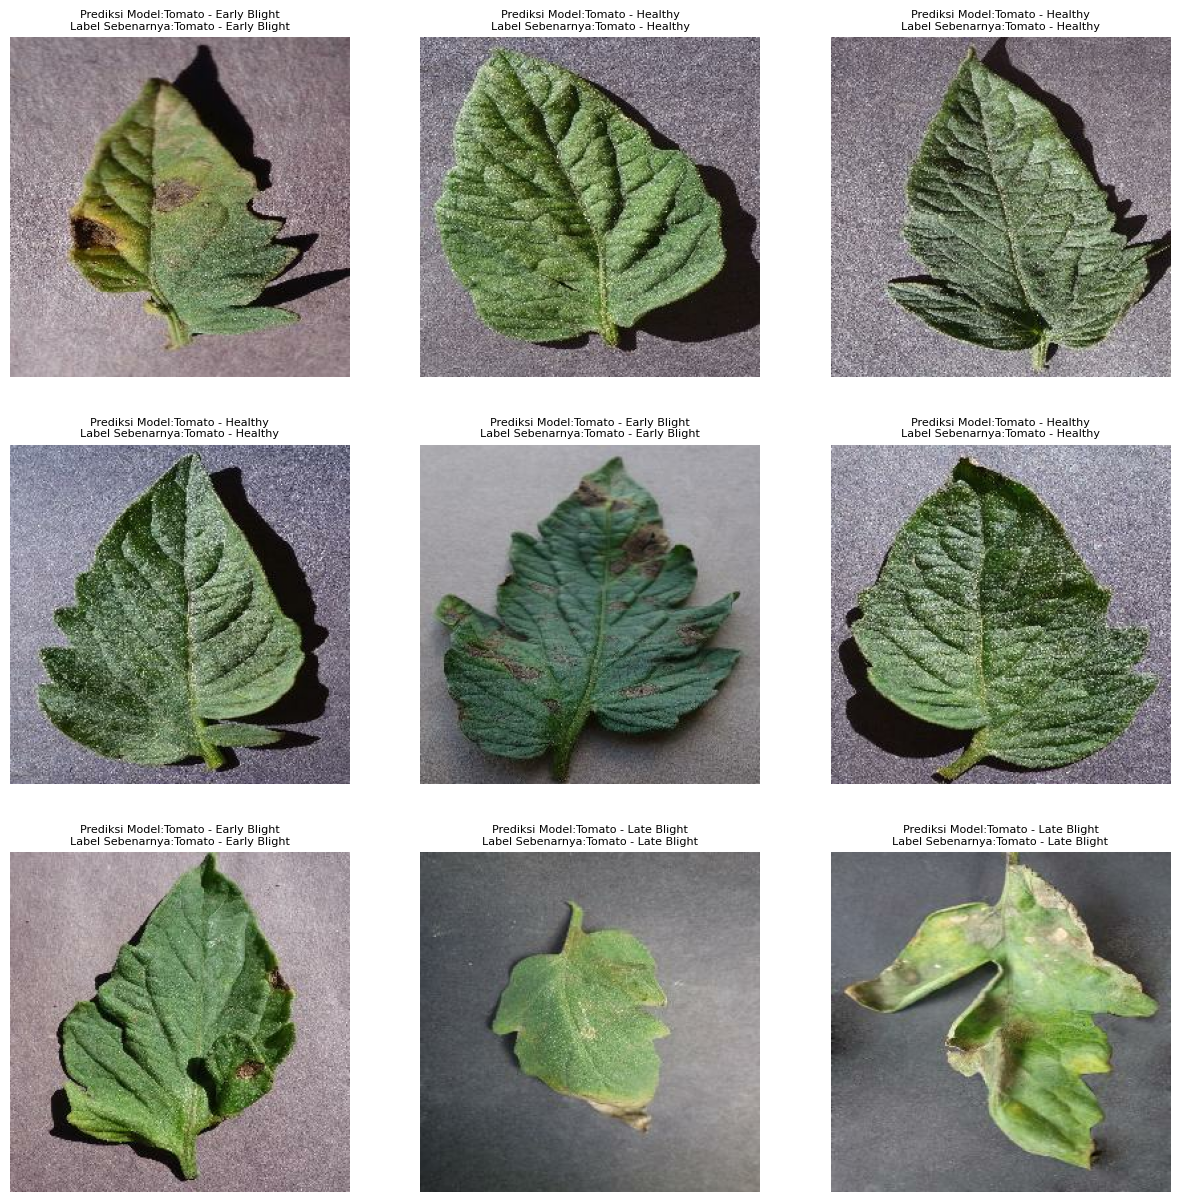

In [19]:
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.title("Prediksi Model:{0}\nLabel Sebenarnya:{1}".format(class_names[np.argmax(prediction[i])],class_names[labels_batch[i]]), fontsize = 8)
  plt.axis("off")

## Save Model

In [20]:
model.save("/content/drive/MyDrive/Tutorial/Tubes/Tomato_Model.keras")

## Testing with image from google

In [21]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Tutorial/Tubes/Tomato_Model.keras")

In [23]:
import numpy as np
image = tf.keras.utils.load_img("/content/tomat.JPG", target_size=(256,256)) # Tomato Healthy
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
np.shape(input_arr)

(1, 256, 256, 3)

In [24]:
prediksi = loaded_model.predict(input_arr)

1/1 [==============================] - 2s 2s/step


In [25]:
prediksi

array([[7.9317260e-06, 9.9998915e-01, 2.8521260e-06]], dtype=float32)

In [26]:
print("Prediksi:", class_names[np.argmax(prediksi)])

Prediksi: Tomato - Late Blight


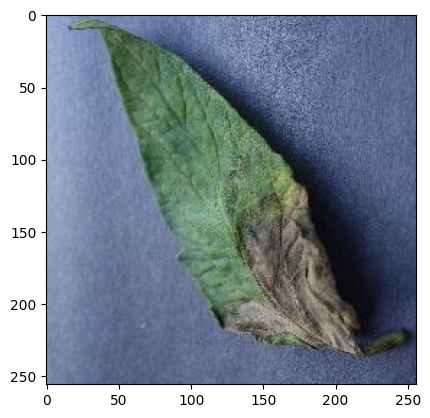

In [27]:
plt.imshow(image)